# Intro

Here we use ALL perturbed cell-types.
This is done when we generate the pseudobulks by sampling from both perturbed or non-perturbed cells within each sample.

This notebook QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.


Data format requirements for single-cell data:
- processed data is not scaled
- cells are filtered such that low-quality cells are removed (for example: filter out cells with less than 200 genes and genes expressed in less than 3 cells, and > 5% MT reads)
- data is saved as an AnnData object and you have sample IDs, gene IDs, and cell-type labels
- In the end we will process the data such that we have the following features in the AnnData object that we will use to generate pseudobulks:
  - the observations have columns named: "sample_id", "stim", "isTraining"
  - sample_id: unique IDs for the samples
  - stim: is "STIM" or "CTRL", denotes if the sample is "Female" or "Male"
  - isTraining: 'Train' or 'Test',  denotes if you can use the sample during training or not. In real use cases, all data will be "Train". To show validation of our experiment, we have access to "Test" data as well. Train and test are separated on the cell level and are stratified by cell-type, sex, and sample ID
  


Pseudobulk features:
- we typically generate 1000 pseudobulks per sample with random proportions
- we generate 100 pseudobulks per sample, per cell type, where the cell-type of interest is >90% of the cell-type
- we typically sample 5000 cells for each pseudobulk

# Imports

In [44]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi

from buddi.preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


In [45]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'buddi.preprocessing.sc_preprocess' from '/Users/davidnat/Documents/projects/greenelab/buddi/buddi/preprocessing/sc_preprocess.py'>

# Parameters

In [46]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/bulk_data/augmented_l1000_data/"

data_path = f"{os.getcwd()}/../../data/bulk_data/l1000/"



#####################
### set the study ###
#####################

res_name = "all-l1000"
in_name = "l1000_bulk_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [47]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [48]:
adata.obs

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,stim,sample_id
distil_id,,,,,,,,,,,,,,
DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21,DOS034_A549_24H:I21,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,24,h,24 h,DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21,CTRL,DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21
CPC017_MCF7_6H_X1_B4_DUO52HI53LO.F06,CPC017_MCF7_6H:F06,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,6,h,6 h,CPC017_MCF7_6H_X1_B4_DUO52HI53LO.F06,CTRL,CPC017_MCF7_6H_X1_B4_DUO52HI53LO.F06
CPC005_A549_6H_X3_B3_DUO52HI53LO.M10,CPC005_A549_6H:M10,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,6,h,6 h,CPC005_A549_6H_X3_B3_DUO52HI53LO.M10,CTRL,CPC005_A549_6H_X3_B3_DUO52HI53LO.M10
DOS032_A549_24H_X1_F3B3_DUO52HI53LO.I06,DOS032_A549_24H:I06,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,24,h,24 h,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.I06,CTRL,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.I06
DOS032_A549_24H_X1_F3B3_DUO52HI53LO.L15,DOS032_A549_24H:L15,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,24,h,24 h,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.L15,CTRL,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.L15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPC008_MCF7_24H_X5_B5_DUO52HI53LO.I15,CPC008_MCF7_24H:I15,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,24,h,24 h,CPC008_MCF7_24H_X5_B5_DUO52HI53LO.I15,CTRL,CPC008_MCF7_24H_X5_B5_DUO52HI53LO.I15
CPC017_MCF7_24H_X5_B5_DUO52HI53LO.M09,CPC017_MCF7_24H:M09,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,24,h,24 h,CPC017_MCF7_24H_X5_B5_DUO52HI53LO.M09,CTRL,CPC017_MCF7_24H_X5_B5_DUO52HI53LO.M09
DOS047_MCF7_24H_X1_F2B4_DUO52HI53LO.M14,DOS047_MCF7_24H:M14,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,24,h,24 h,DOS047_MCF7_24H_X1_F2B4_DUO52HI53LO.M14,CTRL,DOS047_MCF7_24H_X1_F2B4_DUO52HI53LO.M14


In [49]:

tab = adata.obs.groupby(['stim', 'cell_id']).size()

tab.unstack()

cell_id,A549,MCF7
stim,,
CTRL,2052,3472
STIM,149,331


In [72]:
adata.shape

(6004, 978)

In [73]:
np.corrcoef(adata.X[0], adata.X[6000])

array([[1.        , 0.69839591],
       [0.69839591, 1.        ]])

In [50]:
# remove MCF7 stim

keep_idx = np.where((adata.obs.stim != "STIM") | (adata.obs.cell_id != "MCF7"))[0]
temp = adata.obs.iloc[keep_idx]

#adata = adata[keep_idx]

tab = adata.obs.groupby(['stim', 'cell_id']).size()

tab.unstack()

cell_id,A549,MCF7
stim,,
CTRL,2052,3472
STIM,149,331


In [51]:
adata.var

,pr_gene_id,pr_gene_symbol,gene_ids
pr_gene_symbol,,,
AARS,16,AARS,AARS
ABCF1,23,ABCF1,ABCF1
ABL1,25,ABL1,ABL1
ACAA1,30,ACAA1,ACAA1
ACAT2,39,ACAT2,ACAT2
...,...,...,...
TXLNA,200081,TXLNA,TXLNA
SPRED2,200734,SPRED2,SPRED2
EML3,256364,EML3,EML3


In [52]:
# now make half of the MCF7 cells STIM
mcf7_idx = np.where(adata.obs["cell_id"] == "MCF7")[0]
mcf7_idx_rand = np.random.choice(mcf7_idx, np.int(len(mcf7_idx)/2))

#adata.obs.stim.iloc[mcf7_idx_rand] = "STIM"

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_46496/3371136560.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mcf7_idx_rand = np.random.choice(mcf7_idx, np.int(len(mcf7_idx)/2))


In [53]:
# format metadata



adata.obs['CellType'] = adata.obs['cell_id'].tolist()
adata.obs['scpred_CellType'] = adata.obs['cell_id'].tolist()

adata.var.index = adata.var['gene_ids']


In [54]:
adata.obs.columns

Index(['sig_id', 'pert_id', 'pert_iname', 'pert_type', 'cell_id', 'pert_dose',
       'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_time_unit',
       'pert_itime', 'distil_id', 'stim', 'sample_id', 'CellType',
       'scpred_CellType'],
      dtype='object')

### Preprocess

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


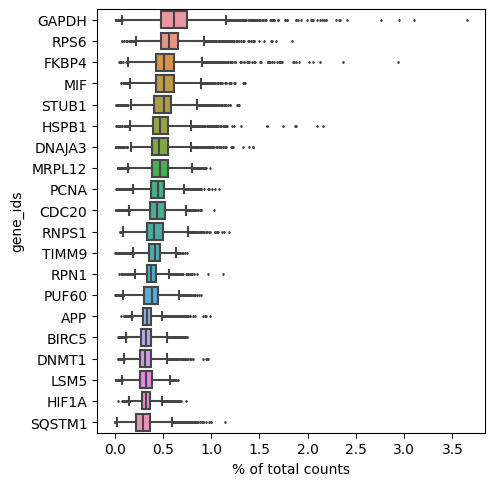

In [55]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [56]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


MCF7    3803
A549    2201
Name: scpred_CellType, dtype: int64

# Plot Data

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


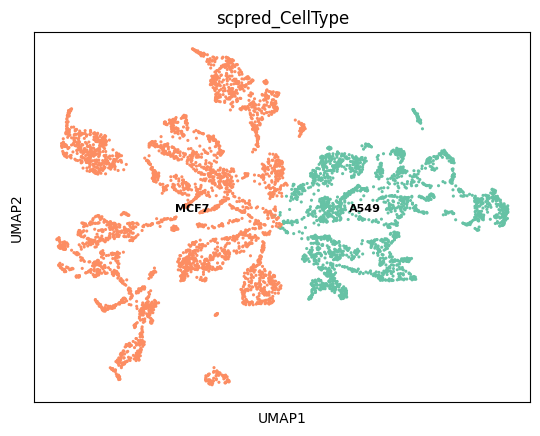

In [57]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [58]:
adata.obs["sample_id"].value_counts()


DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21     1
DEB001_MCF7_24H_X5_F1B6_DUO52HI53LO.M24     1
DOS046_A549_24H_X3_F3B4_DUO52HI53LO.I21     1
DOS060_A549_24H_X1_F3B4_DUO52HI53LO.F10     1
DOS055_MCF7_24H_X2_F2B3_DUO52HI53LO.M10     1
                                           ..
RAD001_A549_6H_X3_F1B5_DUO52HI53LO.A20      1
MUC.CP003_MCF7_24H_X3_B7_DUO52HI53LO.A17    1
CPC013_A549_24H_X3_F1B6_DUO52HI53LO.I16     1
DOS055_A549_24H_X3_F3B4_DUO52HI53LO.D12     1
CPC016_MCF7_24H_X3_B4_DUO52HI53LO.F05       1
Name: sample_id, Length: 6004, dtype: int64

In [59]:
adata.obs

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,stim,sample_id,CellType,scpred_CellType
distil_id,,,,,,,,,,,,,,,,
DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21,DOS034_A549_24H:I21,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,24,h,24 h,DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21,CTRL,DOS034_A549_24H_X2_F2B4_DUO52HI53LO.I21,A549,A549
CPC017_MCF7_6H_X1_B4_DUO52HI53LO.F06,CPC017_MCF7_6H:F06,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,6,h,6 h,CPC017_MCF7_6H_X1_B4_DUO52HI53LO.F06,CTRL,CPC017_MCF7_6H_X1_B4_DUO52HI53LO.F06,MCF7,MCF7
CPC005_A549_6H_X3_B3_DUO52HI53LO.M10,CPC005_A549_6H:M10,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,6,h,6 h,CPC005_A549_6H_X3_B3_DUO52HI53LO.M10,CTRL,CPC005_A549_6H_X3_B3_DUO52HI53LO.M10,A549,A549
DOS032_A549_24H_X1_F3B3_DUO52HI53LO.I06,DOS032_A549_24H:I06,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,24,h,24 h,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.I06,CTRL,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.I06,A549,A549
DOS032_A549_24H_X1_F3B3_DUO52HI53LO.L15,DOS032_A549_24H:L15,DMSO,DMSO,ctl_vehicle,A549,-666.0,-666,-666,24,h,24 h,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.L15,CTRL,DOS032_A549_24H_X1_F3B3_DUO52HI53LO.L15,A549,A549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPC008_MCF7_24H_X5_B5_DUO52HI53LO.I15,CPC008_MCF7_24H:I15,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,24,h,24 h,CPC008_MCF7_24H_X5_B5_DUO52HI53LO.I15,CTRL,CPC008_MCF7_24H_X5_B5_DUO52HI53LO.I15,MCF7,MCF7
CPC017_MCF7_24H_X5_B5_DUO52HI53LO.M09,CPC017_MCF7_24H:M09,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,24,h,24 h,CPC017_MCF7_24H_X5_B5_DUO52HI53LO.M09,CTRL,CPC017_MCF7_24H_X5_B5_DUO52HI53LO.M09,MCF7,MCF7
DOS047_MCF7_24H_X1_F2B4_DUO52HI53LO.M14,DOS047_MCF7_24H:M14,DMSO,DMSO,ctl_vehicle,MCF7,-666.0,-666,-666,24,h,24 h,DOS047_MCF7_24H_X1_F2B4_DUO52HI53LO.M14,CTRL,DOS047_MCF7_24H_X1_F2B4_DUO52HI53LO.M14,MCF7,MCF7


In [60]:
adata.obs["scpred_CellType"].unique()

['A549', 'MCF7']
Categories (2, object): ['A549', 'MCF7']

### now split test and train cells

In [61]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"


In [62]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['stim', 'isTraining']).size()

tab.unstack()

isTraining,Train
stim,
CTRL,5524
STIM,480


## Make pseudobulks

In [63]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'buddi.preprocessing.sc_preprocess' from '/Users/davidnat/Documents/projects/greenelab/buddi/buddi/preprocessing/sc_preprocess.py'>

In [66]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 2
idx = 0
curr_samp = "samp_l1000"
for curr_stim in stim_order:
    for curr_train in train_order:

      print(f"running {curr_samp} {curr_stim} {curr_train}")


      # make the pseudobulks
      subset_idx = np.where(np.logical_and(adata.obs.stim == curr_stim, adata.obs.isTraining == curr_train))[0]
      if len(subset_idx) == 0:
          continue
      
      temp_adata = adata[subset_idx]

      print("make_prop_and_sum")
      prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(temp_adata, 
                                                                              num_samples=5000, 
                                                                              num_cells=num_cells,
                                                                              use_true_prop=False,
                                                                              cell_noise=cell_noise,
                                                                              useSampleNoise=False)
      # number of random pseudobulks
      num_rand_pseudo = pseudobulks_df.shape[0] 

 
      # make the metadata
      num_samps = pseudobulks_df.shape[0] 
      samp_type = ["bulk"]*num_samps
      cell_prop_type = ["random"]*num_rand_pseudo 
      samp_type = ["sc_ref"]*(num_rand_pseudo)
      
      metadata_df = pd.DataFrame(data = {"sample_id":[curr_samp]*num_samps, 
                                        "stim":[curr_stim]*num_samps,
                                        "isTraining":[curr_train]*num_samps,
                                        "cell_prop_type":cell_prop_type,
                                        "samp_type":samp_type,})

      # make the proportions instead of cell counts
      prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
      pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
      prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")
      meta_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_meta_splits.pkl")

      print("write")        
      pseudobulk_path = Path(pseudobulk_file)
      prop_path = Path(prop_file)
      meta_path = Path(meta_file)
      pickle.dump( prop_df, open( prop_path, "wb" ) )
      pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )
      pickle.dump( metadata_df, open( meta_path, "wb" ) )





running samp_l1000 STIM Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
write
running samp_l1000 STIM Test
running samp_l1000 CTRL Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
write
running samp_l1000 CTRL Test
